# Tutorial 1. Shortest Path

## Shortest Path (Dijkstra's) in OSM driving network between residential buildings and Rautatieasema

![map1](img/output-map1.png)

## Introduction
In this Lesson 1, we are going to process the *Shortest Path* between every buildings registered in OpenStreetMap (OSM) to the Rautatieasema. This practice gives an overview about the *accessibility* of the population to the Helsinki city center considering the central railway station as the central point. The *Dijkstra's algorithm* can be applied in the OSM driving network using the Python library OSMnx which operates network analysis under the hood using NetworkX. The newest version of OSMnx implements *Core Parallelization* so we can operate the routing in parallel in your available cores.

## Datasets
Both datasets are fetched during the workflow from OSM using the OSMnx and they are:

- Buildings footprint in the main central area of Helsinki Region (x Km radius)
- Central railway station - Rautatieasema

## Output
The process gives as output a layer with all the routes from every buildings in the Helsinki Region to the Rautatieasema

*Find the a map of the results at the beginning of this notebook*

## Objective
To compare the advantage of processing time of *Shortest Path* algorithm in the Helsinki Region using parallel computing

## Limitation
In this example, if you define a small radius the study area will fetch a small amount of buildings and then the number of shortest paths computed will be small. 

**If you compute less than ~1000 shortest path will take longer time processing in Parallel than with a single core. The benefit of using Parallelization start when you compute over ~2000 shortest paths**

## Resources

CSC Machine-Puhti:

- *Partition*: small
- *CPU Cores*: 8
- *Memory (GB)*: 60
- *Local Disk (GB)*: 120

## Shortest Path preparation
Follow the instructions and run every cell in the supercomputer.

## Importing Python libraries

Be sure that you have installed the OSMnx>=1.6.0 in your environment. Get familiar with this library reading a bit the [OSMnx Documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html)


In [1]:
import os
import glob
# os.environ['USE_PYGEOS'] = '0'

# for (geospatial) analysis
import geopandas as gpd
from shapely.geometry import MultiLineString
from shapely import ops
import osmnx as ox

import pandas as pd

import matplotlib.pyplot as plt

# for optimization of computational resources
from joblib import Memory
import multiprocessing as mp

# time processing
import time
import warnings
warnings.filterwarnings('ignore')

We are going to create a folder `output` where the results are going to be stored

In [45]:
# results folder
if not os.path.exists('output'):
    os.makedirs('output')

## Define the study area

We are going to define a certain radius from the Central Railway Station as our study area. The process in a small area will show the benefits of using parallelization in a short processing time. If you are are willing to check a long run example check the Readme file.

In [9]:
def get_Rautatieasema_gfd():
    '''
    Give back Rautatori Point geometry in WGS84 from OSM
        Return Point geometry 
    '''
    # Geocode the address
    station = ox.geocoder.geocode_to_gdf("Helsinki Central Railway station")
    
    # reset index
    station = station.reset_index(drop=False)
    station = station[['name', 'geometry']]
    
    # get centroid - avoid warning getting the centroid in local CRS for more accuracy
    station['geometry'] = station.to_crs(3067).centroid.to_crs(4326)
    
    return station

Use the function with a defined radius.

The library `geopandas` for spatial analysis contains a function `explore()` that allows you to visualize data in a quick and interactive way. We will add some keywords to modify a bit our visualization

In [7]:
# fetch rautatieasema as geodataframe
rautatieasema = get_Rautatieasema_gfd()

# make a copy for study area
study_area = rautatieasema.copy()

## Define radius

Add a selected `radius` for defining the study area.

In [11]:
# add a radius in crs 3067 (Finnish crs)

RADIUS = 6000 # <---- meters

# create study area geometry
study_area.geometry = study_area.geometry.to_crs(3067).buffer(RADIUS).to_crs(4326)

# visualize study area
study_area.explore()

## Fetch OSM residential buildings

To fetch OSM features you need to define an area like the Helsinki Region and the feature tag like buldings. You can find each one in the next links:

- For OSM areas: [*Nominatim*](https://nominatim.openstreetmap.org/ui/search.html?q=%27Capital+region%2C+Mainland+Finland%2C+Finland%27)
- For feature tags: [*OSM Wiki*](https://wiki.openstreetmap.org/wiki/Buildings)

The administrative defined areas (Helsinki Region) are used when fetching elements from OSM using place names wiht the function `features_from_place()`. But in this case, as we are fetching from a self made study area we need to use the function `features_from_polygon()`.

In [49]:
# ------> Fetch residential buildings

# get geometry of Rautatieasema
place_geom = study_area.geometry[0]

# Tags for residential buildings
tags = {'building': 'residential'}

# run
all_buildings = ox.features_from_polygon(place_geom, tags)

Once you have fetched the buildings you will see that it contains double index and many columns. We will simplify this to have a more kneat frame of the data simple by deleting the indexes and keeping only the `street name` and the `geometry`.

In [50]:
# ------> Reset index and get street name

all_buildings = all_buildings.reset_index(drop=False)
all_buildings = all_buildings[['osmid', 'addr:street', 'geometry']]

# rename
all_buildings = all_buildings.rename(columns={'addr:street':'street_name'})

The geometry of the buildings are represented by **points** and **polygons**. What we need to have is only points because the *Shortest Path* analysis runs between two points (longitude and latitude) so we will add the `centroid` of every geometry to remove the polygons and keep them as centroids.

In [51]:
# fix geometries
all_buildings['geometry'] = all_buildings['geometry'].apply(lambda geom: geom.centroid)

Here is a quick view of the buildings data.

In [52]:
print(f'In total {len(all_buildings)}')

all_buildings.head()

In total 5378


,osmid,street_name,geometry
0,930663425,Marjatie,POINT (24.98284 60.25331)
1,4266889,Servin Maijan tie,POINT (24.83679 60.19060)
2,15505174,Karhutie,POINT (25.03614 60.20457)
3,15505279,Karhutie,POINT (25.03645 60.20501)
4,15505332,Karhutie,POINT (25.03642 60.20482)


Let's use `explore()` to see our buildings. 

In [53]:
print(f'Total residential buildings: {len(all_buildings)}')

all_buildings.explore(color='red', 
                      tiles='CartoDB positron',
                      marker_kwds={'radius':4, 'alpha':0.6},
                      style_kwds={'stroke':False})

Total residential buildings: 5378


## Define Origins as a List

A particularity of the *Shortest Path* function in OSMnx is that you can process A-Origin to A-Destination. Also, you can process pair routes as Lists in a way that `[A-Origin, B-Origin, C-Origin, ...]` to `[A-Destination, B-Destination, C-Destination, ...]`.

Based on this feature of the OSMnx library we are going to start organizing a List `all_origins` that contains *geometry* objects of every building we have fetched from OSM in the Helsinki Region.

In [54]:
# --------> define origin List

# list
all_origins = []

for row in all_buildings.itertuples(index=True):
        
    # tuple, only geometries
    geom = row.geometry
    
    all_origins.append(geom)

In [55]:
all_origins[:5]

[<POINT (24.983 60.253)>,
 <POINT (24.837 60.191)>,
 <POINT (25.036 60.205)>,
 <POINT (25.036 60.205)>,
 <POINT (25.036 60.205)>]

## Fetching road network

In this step we are going to fetch the *Graph* object containing the edges (roads) and nodes (interections) of the OSM driving network. As we are using a defined study are the function that we will use is the `graph_from_polygon()` from OSMnx. In case you want to fetch administrative border you might need to use the function `graph_from_place()`

**Note!**

We are going to create a function that packs the OSMnx function. The objective is to add it to `cache` memory.

The library `joblib` is able to cache processed that can be repetitive and optimize the processing in a workflow. This means, that the first time you fetch the *Graph* from OSM will take some time, but the next times will be **inmediate** because the process is cached.

In [56]:
def graph_Helsinki(place_geom, network_type='drive'):
    '''
    Packed function for repetitive running and testing
    
    - place_geom: geom, area defined
    - network_type: string, type of OSM network from drive, bike, walk
    
        return <Function>
    '''
    
    return ox.graph_from_polygon(place_geom, network_type)

Cache the *Graph* fetch

In [57]:
# cache
memory = Memory('cache', verbose=0)
graph_Helsinki_cached = memory.cache(graph_Helsinki)

In [58]:
%%time

# get the road network as graph object
graph = graph_Helsinki_cached(place_geom, network_type='drive')

CPU times: user 714 ms, sys: 17 ms, total: 731 ms
Wall time: 830 ms


The OSMNX function can plot the graph using the `plot_graph()` function. We added some modifications to have a clean view.

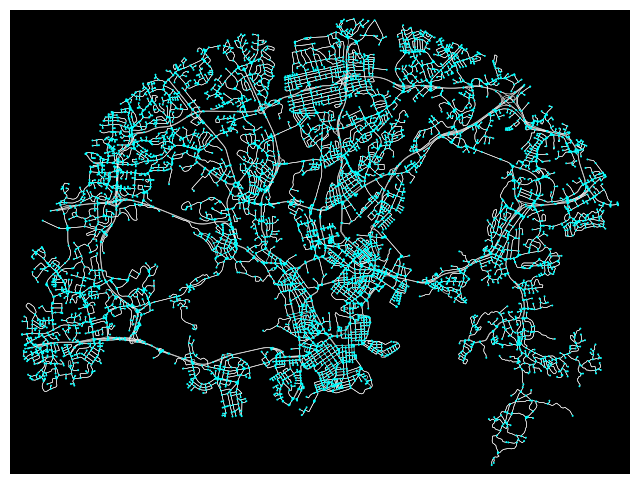

In [59]:
fig, ax = ox.plot_graph(graph, 
                        node_size=2, 
                        node_color='cyan', 
                        edge_linewidth=0.4, 
                        edge_color='white', 
                        bgcolor='black')

## Rautatieasema geometry as a Destination

We have fetched already the location of Rautatieasema as a geodataframe using the function `get_Rauratientori_gfd()`. We will store the *geometry* object in a variable called `destin_geom`.

We will require simply the *geometry* object when routing the Shortest Path. 

Let's have a quick visualization of the location of Rautatieasema.

In [12]:
# Rautatiesema

# geom
destin_geom = rautatieasema.geometry[0]

rautatieasema.explore(color='magenta', 
                      marker_kwds={'radius':50, 'alpha':0.8})

## **A. Calculate Shortest Path using Parallelization (8 Core)**

We are going to run step by step the process of finding the *Shortest Path*. Also, you will see that some steps can be parallelized in the available cores.

The advantage we have separating the workflow is that we are able to run in parallel specific parts of the Shortest Path and it saves time processing

## About the Core Parallelization

To start understanding a bit more the parallel computing let's take a look the available resources in our machine using the next command.


In [61]:
!lscpu | egrep 'Model name|Socket|Thread|NUMA|CPU\(s\)'

CPU(s):              40
On-line CPU(s) list: 0-39
Thread(s) per core:  1
Socket(s):           2
NUMA node(s):        2
Model name:          Intel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz
NUMA node0 CPU(s):   0-19
NUMA node1 CPU(s):   20-39


We can see the number of Cores available in the **CPU(s)** sections. The partition contains in total 40 Cores (depends the machine) but the configuration we specified at the beginning in the machine was 8 Cores or any other number. So? Despite 40 cores are available only 8 cores are *reserved* for our analysis.

We can monitor our processes and the Core utilization with `htop` library that let us visuallize dinamically how the computer is using the resources. If you are willing to monitor your process you should open in a new command line `$ htop` (be sure you are using your own environment)

Let's take a look at the resources utilization after each process.

## Find the Closest Nodes

The *Shortest Path* is operated in the OSM network between nodes (intersections) so the Origin and Destination location are simply a reference that helps to find the closest node where the routing should start.

In the next cells we are going to find the closest nodes using the function `nearest_nodes()` from OSMNX.

The destination and only one geometry of Rautatieasema needs only 1 nearest node. Additionally, the process of finding the closest node of every origin was parellized using the library `multiprocess`.

We are going to start measuring the processing time using simple time variables at the beginning and end of the cell and we will sum up at the end to compare how the efficiency improves using parallel computation.

## A.1 Destination node


In [62]:
s = time.time()

# ---- A1) Closest destination node

closest_target_node = ox.nearest_nodes(G=graph, 
                                       X=destin_geom.x, 
                                       Y=destin_geom.y)


# --------------------------------------------------------
d1 = time.time() - s
print(f' - Closest destination node: {d1} seconds')

 - Closest destination node: 0.02343916893005371 seconds


If you can monitor the processes using `htop` (optional) you will see that we have in total 40 Cores. Some of them are already in use but there are still 16 Cores available for our use. 

This is how the resource utilization looks if you are running the *Destination node* cell

![htop1](img/machine-core-1.png)

As we are running a common process the computer is using a single node: the Core #30. 

## A2. Origins nodes

We have many origins that we should compute and find the closest node. To optimize the time processing we are going to parallelize for every origin.

We will use the Python library `multiprocess` to parallelize the closest node process of the origins. Let's start packing the function `nearest_nodes()` from OSMNX.

In [63]:
print(f'- Processing total routes: {len(all_origins)}')

- Processing total routes: 5378


In [64]:
def get_nearest_node(graph, geom):
    '''
    Packed function to return a closest node from geometry
    
    - graph: graph, osm object
    - origin_geom: point geom, individual
    
        return:: int, a node code
    '''
    
    # calculate node
    node = ox.nearest_nodes(G=graph, X=geom.x, Y=geom.y) 
    
    return node

The `multiprocess` library is able to send a job to every core and optimize the workflows. The step is simple once we have packed the function we are going to use in this case `get_nearest_node()`

**Note**
As a condition, you should be able to loop over the inputs otherwise the process is not going to be parallelized. We are looping over every origin so we can distribute the process in every core.

The variables involved in the parallelization are:

- `cpus`: the number of cores available for computation with `cpu_count()`
- `args`: the parameters of our packed function, looping over every input
- `pool`: a pool opened for every available core where *asyncronize* the process with `starmap_async()`
- `get()`: catch the result of every process in every core and save in a list

Then, you to close the pool you `close()` and `join()`.

In [65]:
s = time.time()

# ----- A2) Closest origins node

# get cores
cpus = mp.cpu_count()

# ----- args

args = ((graph, geom) for geom in all_origins)

# ----- pool - with function

pool = mp.Pool(cpus)
sma = pool.starmap_async(get_nearest_node, args)

# ----- get list of results

closest_origin_node_list = sma.get()
pool.close()
pool.join()


# ----------------------------------------------------------
d2_parallel = time.time() - s
print(f' - Closest node of origins [PARALLELIZED]: {d2_parallel/60} minutes')

 - Closest node of origins [PARALLELIZED]: 0.9359867970148722 minutes


If you monitor the process in `htop` you will notice how the resource utilization changed. (This example with 16 cores)

At first you will see how the Cores start to be used:

![htop2](img/machine-core-starting.png)

Finally, it will occupy the 16 Cores available: 

![htop1](img/machine-core-16.png)

In total 16 Cores: from Core #20 to Core #35 

## A.3 Calculating the Shortest Path

The OSMnx library has implemented the Shortest Path algoritm using the function `shortest_path()`. A particularity of this function is that it create routes based on OD paired-list. For example, if your input is `Origins=[O1, O2, O3]` and `Destinations=[D1, D2, D3]`, the output paths are going to be defined as `[O1 to D1, O2 to D2, O3 to D3]`.

Based on this, we need to have two lists with the same length. As we are using only 1 destination, we will multiply by the length of the origins so we have all routes to the same destination.

Fortunately, the OSMnx library has implemented in the function a parallelization parameter `cpus`. If you want to use all available cores, in this case 8 cores, you need to add `cpus=None` and it will use all available resources.

Follow the next code.

In [66]:
s = time.time()

# ---- target nodes should be same length as origins

closest_target_node_list = [closest_target_node] * len(closest_origin_node_list)

# --------6.7.3) Shortest Path ---------

# run
routes = ox.shortest_path(graph, 
                         orig = closest_origin_node_list, 
                         dest = closest_target_node_list, 
                         weight = 'length',
                         cpus = None) # none takes all cores, default=1


# --------------------------------------------------------------------------

d3_parallel = time.time() - s
print(f' - Shortest Path run [PARALLELIZED]: {d3_parallel/60} minutes')

 - Shortest Path run [PARALLELIZED]: 0.7968805074691773 minutes


As we explained, the routes are defined between nodes, and might be the case that some nodes are too close or the origins are not connect to the network (like islands) so there are no existing routes and in those cases the OSMnx return a `None` object.

In this line we are going to remove the invalid routes.

In [67]:
# remove None values from invalid routes
all_routes = [value for value in routes if value != None]

# check routes length
len(all_routes)

5378

## A.4 From nodes to paths

The output of the Shortest Path is a list of node's codes that construct the route we want. Then, we need to extract the line geometries using those nodes.

Be aware that we can do this work using the already implemented function in OSMnx `utils_graph.route_to_gdf()`. Particularly, it will give a row for each route segment and it will create quite many routes for all the routes we are working on. So, we will create a function `nodes_to_path()` that will transform all nodes to to a single line geometry.

Get familiar with the function.

In [68]:
def nodes_to_path(graph, route_nodes):
    '''
    Function to transform node's path to a single line geometry
    - graph: osm graph object
    - route_nodes: list, nodes of path
        return geodataframe with a single row
    '''
    
    # get route from nodes - get only geom and length
    shortest_route_parallel = ox.utils_graph.route_to_gdf(graph, route_nodes, weight='length')[['length', 'geometry']].reset_index(drop=True)
    
    # join the road segments
    multi_line = MultiLineString([linegeom for linegeom in shortest_route_parallel.geometry])    
    total_length = sum([value for value in shortest_route_parallel['length']])
    
    merged_line = ops.linemerge(multi_line)
    
    # new gdf
    shortest_route_merged = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs=4326)
    shortest_route_merged.at[0, 'geometry'] = merged_line
    shortest_route_merged.at[0, 'length'] = total_length
        
    return shortest_route_merged

Then, we will use again a `pool` from `multiprocess` to parallelize this path geometry creation. You can monitor also the core usage using the `htop`

In [69]:
s = time.time()

# --------- A.4) Get path as geom GDF

# get cores
cpus = mp.cpu_count()

# ----- args

args = ((graph, route_nodes) for route_nodes in all_routes)

# ----- pool - with function

pool = mp.Pool(cpus)
sma = pool.starmap_async(nodes_to_path, args)

# ----- get list of results - GDF

shortest_path_gdf_list = sma.get()
pool.close()
pool.join()

# --------------------------------------------------------------------------

d4_parallel = time.time() - s
print(f' - Nodes to path: {d4_parallel/60} minutes')

 - Nodes to path: 0.8298576315244038 minutes


The output will be a list of Shortest Paths stored in the variable `shortest_path_gdf_list`. We will gather all results into one geodataframe using `concat()` function.

In [70]:
# ------  create a single GDF

all_routes_gdf = pd.concat(shortest_path_gdf_list)  

We have got the length of every route fetching the same column from OSM that probably was calculated at global level. We would like to calculate a more accurate distance computed in a Finnish CRS (3067) so we need to operate a new column and add the newly measured distance.

We will create a function.

In [71]:
def compute_fin_distance(shortest_path_gdf):
    '''
    Compute distance in FinCRS EPSG:3067
    
    - shortest_path_gdf: geodataframe, with geometry colum
        return geodataframe, with additional distance column
    
    '''
    
    # project WGS84 to EPSG3067
    distances = shortest_path_gdf.to_crs("EPSG:3067").geometry.length
    
    # add
    shortest_path_gdf['distance_fincrs'] = distances
    
    return shortest_path_gdf

In [72]:
# ----- Compute distance EPSG FIN

route_distance_gdf = compute_fin_distance(all_routes_gdf)

## A.5 Results

We are going to check how our final geodataframe looks like and count how many routes we have calculated in total.

We will see that there is a slightly difference with distances calculated in the Finnish CRS. If you are going to use this process to calculate statistics it is recommended to do it using the distances from the local CRS.

In [73]:
print(f' - In total {len(all_routes_gdf)} routes processed using 8 cores\n')

route_distance_gdf.head()

 - In total 5378 routes processed using 8 cores



,geometry,length,distance_fincrs
0,"LINESTRING (24.98252 60.25363, 24.98266 60.253...",11398.613,11424.001315
0,"LINESTRING (24.83813 60.19089, 24.83812 60.190...",10027.729,10054.457770
0,"LINESTRING (25.03655 60.20408, 25.03647 60.203...",7559.669,7580.253765
0,"LINESTRING (25.03631 60.20566, 25.03643 60.205...",7746.651,7767.591758
0,"LINESTRING (25.03655 60.20408, 25.03647 60.203...",7559.669,7580.253765


A quick plot to visualize the routes.

In [74]:
# sort values for visualization
all_routes_gdf = all_routes_gdf.sort_values('distance_fincrs', ascending=False)

A visualization using `matplotlib`

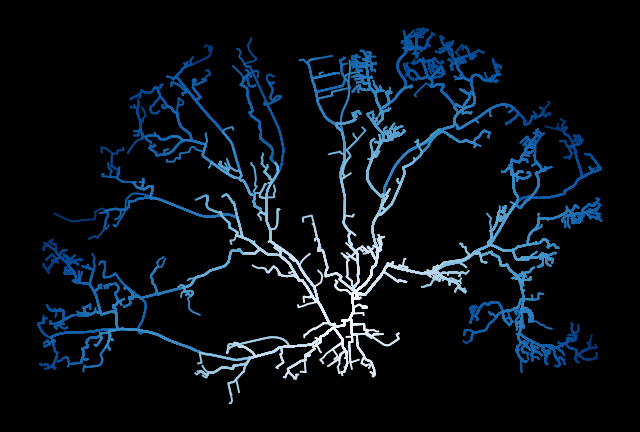

In [75]:
# define a style for the map
plt.style.use('dark_background')

# Plot

# routes
ax = all_routes_gdf.plot(figsize=(8, 8), 
                         column='distance_fincrs', 
                         linewidth=1.4, 
                         cmap='Blues', 
                         alpha=1,
                         zorder=1
                        );

# remove coordinates
ax.axis('off');

plt.savefig('output/shortest_path_parallel_8_core.png', dpi=300)

Finally, we are going to save in our local disk the routes as GIS format. Geopackage in this case.

In [76]:
s = time.time()

# -------- Save

filepath = 'output/shortest_path_parallel_8_core.gpkg'
all_routes_gdf.to_file(filepath, index=False)

# --------------------------------------------------------------------------

dsave1 = time.time() - s
print(f' - Saving time: {dsave1} seconds')

 - Saving time: 2.5035884380340576 seconds


## **B. Calculate Shortest Path with 1 Core**

## Do I have to configure 1 Core?

No, the process by default is run in a single Core, as it was run in a personal laptop. But, in this section there are not modification in the code so parallelization is not active.

## Find the Closest Nodes

As we have already calculated the closest node of the destination we will run only the closest node calculation for the origins, but this time using a single core.


## B.1 Destination nodes

This process we have already done only for Rautatieasema and it is store in the variable `closest_target_node`

In [77]:
closest_target_node

1319789483

## B.2 Origins nodes

We will find the Origins nodes as a list using a single core

In [78]:
s = time.time()

# ----- A2-non) Closest origins node

closest_origin_node_list = [ox.nearest_nodes(G=graph, 
                                           X=origin_geom.x, 
                                           Y=origin_geom.y) 
                               for origin_geom in all_origins]
    
# ----------------------------------------------------------

d2_non = time.time() - s

print(f' - Closest node of origins [NON-PARALLELIZED]: {d2_non/60} minutes')

 - Closest node of origins [NON-PARALLELIZED]: 3.5477376182874045 minutes


## B.3 Calculating the Shortest Path (1 Core)

Then we will run the shortest path using a single core. 

In [79]:
s = time.time()

# ---- target nodes should be same length as origins

closest_target_node_list = [closest_target_node] * len(closest_origin_node_list)

# --------6.8.3) Shortest Path ---------

# run
routes = ox.shortest_path(graph, 
                         orig = closest_origin_node_list, 
                         dest = closest_target_node_list, 
                         weight = 'length',
                         cpus = 1)


# --------------------------------------------------------------------------

d3_non = time.time() - s
print(f' - Shortest Path run [NON-PARALLELIZED]: {d3_non/60} minutes')

 - Shortest Path run [NON-PARALLELIZED]: 1.7060152093569438 minutes


We will remove non valid routes and check how many are valid.

In [80]:
# remove None values from invalid routes
all_routes = [value for value in routes if value != None]

# check routes length
len(all_routes)

5378

## B.4 Nodes to path

The nodes to path are computed in this part with a single core.

Beforehand, the results were gathered in a list using `pool` from parallelization. But now, we are going to loop over each path (as nodes) and use the function previously created that return a single line geometry. On the fly, we will calculate the distance using the Finnish CRS.

Finally, we will have a single geodataframe with all routes.

In [81]:
s = time.time()

# --------- B.4) Get path as geom GDF

all_routes_gdf = gpd.GeoDataFrame()

for each_route in all_routes:
        
    # ----- create nodes path to GDF
    route_gdf = nodes_to_path(graph, each_route)
    
    # ----- Compute distance

    route_distance_gdf = compute_fin_distance(route_gdf)
    
    all_routes_gdf = pd.concat([all_routes_gdf, route_distance_gdf])
    
# --------------------------------------------------------------------------

d4_non = time.time() - s
print(f' - Nodes to path and distances: {d4_non/60} minutes')

 - Nodes to path and distances: 2.276208821932475 minutes


## B.5 Results (1 Core)

Let's take a look at the results.

In [82]:
print(f' - In total {len(all_routes_gdf)} routes processed with 1 core\n')

all_routes_gdf.head()

 - In total 5378 routes processed with 1 core



,geometry,length,distance_fincrs
0,"LINESTRING (24.98252 60.25363, 24.98266 60.253...",11398.613,11424.001315
0,"LINESTRING (24.83813 60.19089, 24.83812 60.190...",10027.729,10054.457770
0,"LINESTRING (25.03655 60.20408, 25.03647 60.203...",7559.669,7580.253765
0,"LINESTRING (25.03631 60.20566, 25.03643 60.205...",7746.651,7767.591758
0,"LINESTRING (25.03655 60.20408, 25.03647 60.203...",7559.669,7580.253765


In [83]:
# sort values for visualization
all_routes_gdf = all_routes_gdf.sort_values('distance_fincrs', ascending=False)

With `maptplotlib`

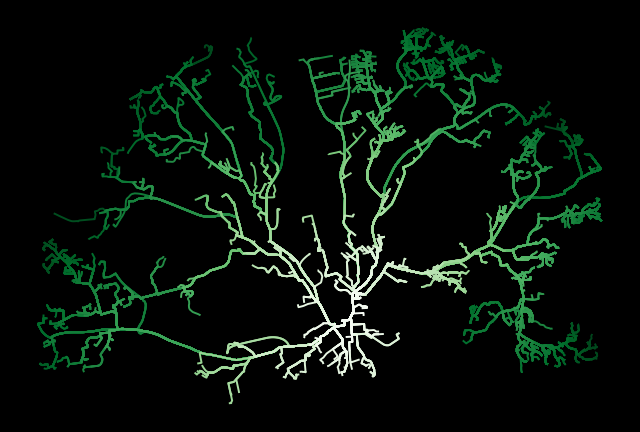

In [84]:
# define a style for the map
plt.style.use('dark_background')

# Plot

# routes
ax = all_routes_gdf.plot(figsize=(8, 8), 
                         column='distance_fincrs', 
                         linewidth=1.4, 
                         cmap='Greens', 
                         alpha=1,
                         zorder=1
                        );

# remove coordinates
ax.axis('off');

plt.savefig('output/shortest_path_parallel_1_core.png', dpi=300)

We will save the results.

In [85]:
s = time.time()

# -------- Save

filepath = 'output/shortest_path_parallel_1_core.gpkg'
all_routes_gdf.to_file(filepath, index=False)

# --------------------------------------------------------------------------

dsave2 = time.time() - s
print(f' - Saving time: {dsave2} seconds')

 - Saving time: 15.507724523544312 seconds


## Summary

We are going to print the sum of all processing times and compare how benefitial was to use the parallelization. Be aware that:

- `d1` corresponds to the closest node of destination ()
- `d2` corresponds to the closest node of origins (buildings)
- `d3` corresponds to the shortest path calculation
- `d4` corresponds to the transformation from nodes to line geometry

Then, saving times are separated. Both should be the same time.

In [86]:
print(f'--------------------- PROCESSING TIME --------------------\n')

total_parallel = d1 + d2_parallel + d3_parallel + d4_parallel

print(f'--> Total parallel time : {round(total_parallel/60, 2)} mins -> 8 Core')

total_non = d1 + d2_non + d3_non + d4_non

print(f'--> Total time : {round(total_non/60, 2)} mins -> 1 Core')

print(f'\n--------------------- TIME PROCESSING BENEFIT --------------------\n')

print(f'--> % of improvement : {round(((total_non-total_parallel)/total_non)*100, 1)}%')
print(f'--> n paths : {len(all_routes_gdf)}')

--------------------- PROCESSING TIME --------------------

--> Total parallel time : 2.56 mins -> 8 Core
--> Total time : 7.53 mins -> 1 Core

--------------------- TIME PROCESSING BENEFIT --------------------

--> % of improvement : 66.0%
--> n paths : 5378
